Specificity plot created


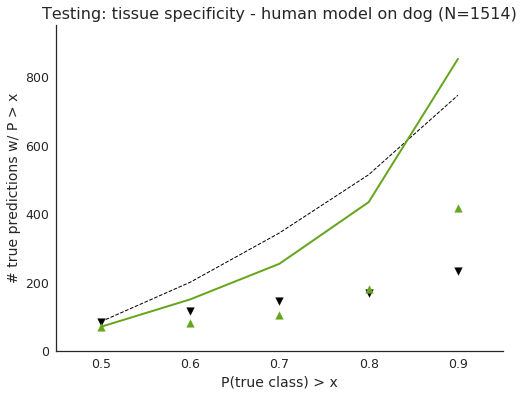

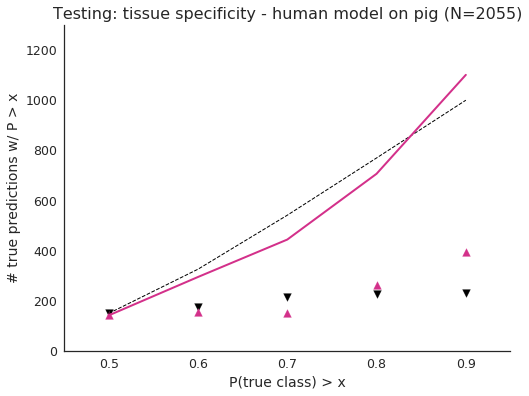

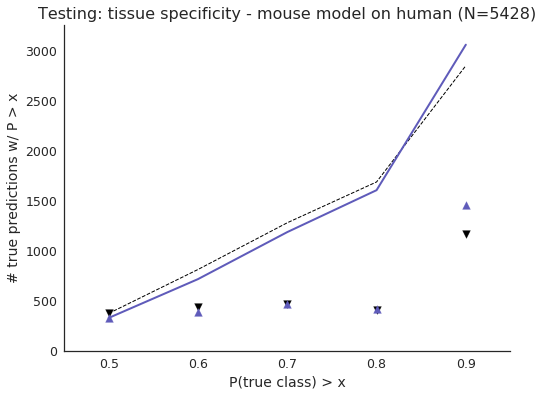

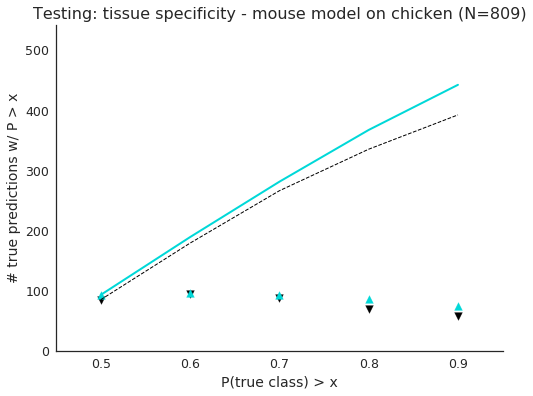

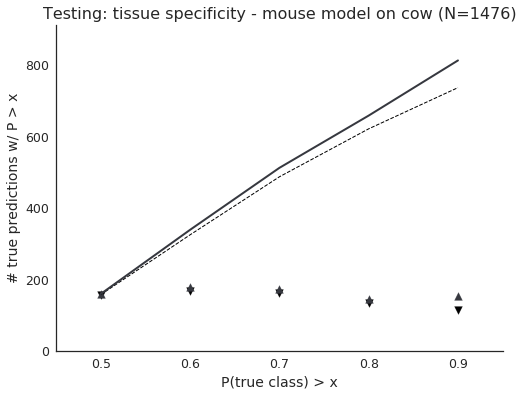

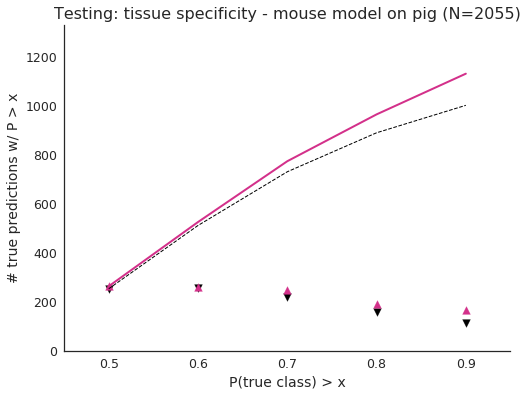

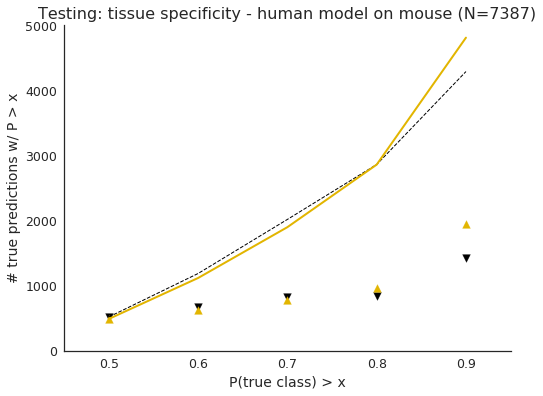

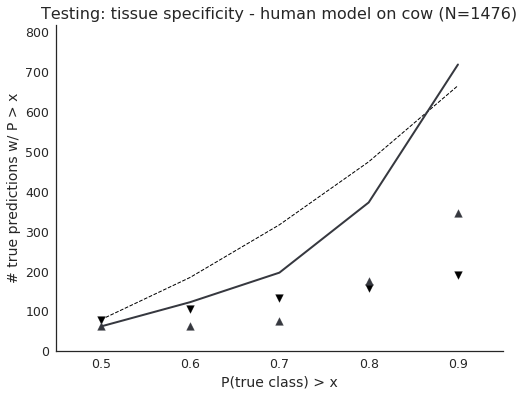

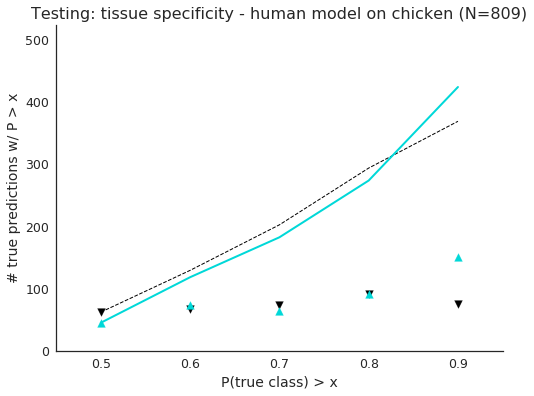

In [4]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import json as js
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
stat_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize')
stat_file = os.path.join(stat_folder, 'agg_expstat_est.h5')
ortho_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')
ortho_pred = os.path.join(ortho_folder, 'orthopred_odb_6species.h5')

cache_dir = '/home/pebert/.jupyter/cache'

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))

run_exec_specificity = True

show_figures = True
use_hatched_bars = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

def exec_specificity():
    cache_data = os.path.join(cache_dir, 'plot_tissue_specific.pck')
    if not run_exec_specificity:
        return False
    if os.path.isfile(cache_data):
        dump = pck.load(open(cache_data, 'rb'))
        pos_perf, neg_perf = dump['pos'], dump['neg']
    else:
        pos_perf = collect_model_stat_perf(stat_file, dict(), 'pos', 'asig')
        neg_perf = collect_model_stat_perf(stat_file, dict(), 'neg', 'asig')
        with open(cache_data, 'wb') as out:
            print('Writing cache file for specificity plot')
            pck.dump({'pos': pos_perf, 'neg': neg_perf}, out)
    for (spec_a, spec_b), pos in pos_perf.items():
        neg = neg_perf[(spec_a, spec_b)]
        if spec_a == 'mouse' and spec_b == 'dog':
            continue
        pos_color = plot_colors['species'][spec_b]['rgb']
        
        data_values = [pos['data_crp_asig_p060'], neg['data_crp_asig_p060'],
                       pos['data_crp_asig_p070'], neg['data_crp_asig_p070'],
                       pos['data_crp_asig_p080'], neg['data_crp_asig_p080'],
                       pos['data_crp_asig_p090'], neg['data_crp_asig_p090'],
                       pos['data_crp_asig_p100'], neg['data_crp_asig_p100']]
        max_value = pos['max_all']
        plot_title = 'Testing: tissue specificity - {} model on {} (N={})'.format(spec_a, spec_b, max_value)
        fig, exart = plot_spec_linechart(max_value, data_values, plot_title, pos_color,
                                         '# true predictions w/ P > x', 'P(true class) > x')

        if save_figures:
            outpath = os.path.join(out_folder, 'main', 'fig_X_main_{}-to-{}_tissue_spec.svg'.format(spec_a, spec_b))
            #fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            outpath = outpath.replace('.svg', '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
    return True
       

def plot_spec_linechart(maxval, datavals, title, poscolor, ylabel, xlabel):
    """
    """
    pos_shape = '^'
    neg_shape = 'v'
    max_shape = 'x'
    marker_size = 60
    #coords = get_xlocs(first_xloc, bar_width, 1, [5])
    
    get_rf_pos = op.itemgetter(*(0, 2, 4, 6, 8))
    get_rf_neg = op.itemgetter(*(1, 3, 5, 7, 9))
    
    mean_pos = [np.round(np.mean(v), 0) for v in get_rf_pos(datavals)]
    mean_neg = [np.round(np.mean(v), 0) for v in get_rf_neg(datavals)]
    cum_pos = np.cumsum(mean_pos)
    cum_neg = np.cumsum(mean_neg)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    extra_artists = []
    ax.set_xlim(0.45, 0.95)
    ylim = np.ceil(np.max(cum_pos))
    if ylim < 1000:
        ylim += 100
    else:
        ylim += 200
    ax.set_ylim(0, ylim)
       
    xtick_loc = [0.5, 0.6, 0.7, 0.8, 0.9]
    xtick_labels = [str(xl) for xl in xtick_loc]
    
    #max_scatter = ax.scatter([0.9], maxval, color='black',
    #                         marker=max_shape, s=marker_size)
    
    neg_line = ax.plot(xtick_loc, cum_neg, lw=1, ls='--', color='black')
    
    neg_scatter = ax.scatter(xtick_loc, mean_neg, color='black',
                             marker=neg_shape, s=marker_size)
    
    pos_line = ax.plot(xtick_loc, cum_pos, color=poscolor, lw=2, ls='solid')
    
    pos_scatter = ax.scatter(xtick_loc, mean_pos, color=poscolor,
                             marker=pos_shape, s=marker_size)   
     

#     rf_seq_leg = mpatches.Patch(facecolor='white', label='RF-seq.',
#                                 hatch='\\', edgecolor='black',
#                                 ls='solid', lw=1)
#     rf_epi_leg = mpatches.Patch(facecolor='white', label='RF-epi.',
#                                 hatch='', edgecolor='black',
#                                 ls='solid', lw=1)
#     orth_leg = mpatches.Patch(facecolor='white', label='Orth.',
#                             hatch='//', edgecolor='black',
#                             ls='solid', lw=1)
#     model_handles = [orth_leg, rf_seq_leg, rf_epi_leg]

#     leg_models = plt.legend(handles=model_handles, loc=1, title='Models',
#                             markerscale=1.5, fontsize=14, bbox_to_anchor=(1.25, 0.9))
#     extra_artists.append(leg_models)
    
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, extra_artists


def collect_model_stat_perf(fpath, data_collect, scenario, model):
    """
    """
    with pd.HDFStore(fpath, 'r') as hdf:
        load_keys = [k for k in hdf.keys() if k.startswith('/'.join(['', scenario, model])) and k.endswith('/metadata')]
        for k in load_keys:
            if any([c in k for c in ['GM12878', 'CH12', 'K562', 'MEL']]):
                continue
            md = hdf[k]
            spec_a = md.loc['target_spec',:][0]
            spec_b = md.loc['query_spec',:][0]            
            if (spec_a, spec_b) not in data_collect:
                data_collect[(spec_a, spec_b)] = {'max_all': 0,
                                                  'data_crp_{}_p060'.format(model): [],
                                                  'data_crp_{}_p070'.format(model): [],
                                                  'data_crp_{}_p080'.format(model): [],
                                                  'data_crp_{}_p090'.format(model): [],
                                                  'data_crp_{}_p100'.format(model): []}
            num_samples_all = int(md.loc['perf_switch_true',:][0]) + int(md.loc['perf_switch_false',:][0])
            data_collect[(spec_a, spec_b)]['max_all'] = num_samples_all
            count = int(md.loc['perf_switch_p060',:][0])
            data_collect[(spec_a, spec_b)]['data_crp_{}_p060'.format(model)].append(count)
            count = int(md.loc['perf_switch_p070',:][0])
            data_collect[(spec_a, spec_b)]['data_crp_{}_p070'.format(model)].append(count)
            count = int(md.loc['perf_switch_p080',:][0])
            data_collect[(spec_a, spec_b)]['data_crp_{}_p080'.format(model)].append(count)
            count = int(md.loc['perf_switch_p090',:][0])
            data_collect[(spec_a, spec_b)]['data_crp_{}_p090'.format(model)].append(count)
            count = int(md.loc['perf_switch_p100',:][0])
            data_collect[(spec_a, spec_b)]['data_crp_{}_p100'.format(model)].append(count)
    return data_collect


execd = exec_specificity()
if execd:
    print('Specificity plot created')
